# Ungraded Lab: Feature Selection

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of your model, as well as minimizing the resources required for training and inference. This has greater effect in production models where you maybe dealing with terabytes of data or serving millions of requests.

In this notebook, you will run through the different techniques in performing feature selection on the [Breast Cancer Dataset](http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29). Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Imports

In [5]:
# for data processing and manipulation
import pandas as pd
import numpy as np

# scikit-learn modules for feature selection and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import zipfile
import os

## Load the dataset

We've already downloaded the CSV in your workspace. Run the cell below to load it in the lab environment and inspect its properties.

In [2]:
!wget https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.zip

--2023-11-04 14:10:28--  https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘breast+cancer+wisconsin+diagnostic.zip’

breast+cancer+wisco     [  <=>               ]  50.08K   163KB/s    in 0.3s    

2023-11-04 14:10:29 (163 KB/s) - ‘breast+cancer+wisconsin+diagnostic.zip’ saved [51284]



In [3]:
breast_cancer_data_zip = 'breast+cancer+wisconsin+diagnostic.zip'

In [15]:
# directory of the raw data files
_data_root = './data/cancer'
os.makedirs(_data_root, exist_ok=True)

with zipfile.ZipFile(breast_cancer_data_zip, 'r') as my_zip:
  my_zip.extractall(_data_root)

# Define the header
header = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
    'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
    'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
    'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst',
    'symmetry_worst', 'fractal_dimension_worst', 'unnamed'
]

# Load the dataset into a DataFrame with the specified header
df = pd.read_csv(os.path.join(_data_root, 'wdbc.data'), names=header)

# Save the DataFrame to a CSV file with the specified header
df.to_csv(os.path.join(_data_root, 'breast_cancer_data.csv'), index=False)

In [16]:
ls data/cancer

breast_cancer_data.csv  wdbc.data  wdbc.names


In [17]:
# Load the dataset
df = pd.read_csv('./data/cancer/breast_cancer_data.csv')

# Print datatypes
print(df.dtypes)

# Describe columns
df.describe(include='all')

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,unnamed
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


In [18]:
# Preview the dataset
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,unnamed
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Remove Unwanted Features

You can remove features that are not needed when making predictions. The column `Unnamed: 32` has `NaN` values for all rows. Moreover, the `id` is just an arbitrary number assigned to patients and has nothing to do with the diagnosis. Hence, you can remove them from the dataset.

In [19]:
# Check if there are null values in any of the columns. You will see `Unnamed: 32` has a lot.
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
unnamed 

In [20]:
# Remove Unnamed: 32 and id columns
columns_to_remove = ['unnamed', 'id']
df.drop(columns_to_remove, axis=1, inplace=True)

# Check that the columns are indeed dropped
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Integer Encode Diagnosis

You may have realized that the target column, `diagnosis`, is encoded as a string type categorical variable: `M` for malignant and `B` for benign. You need to convert these into integers before training the model. Since there are only two classes, you can use `0` for benign and `1` for malignant. Let's create a column `diagnosis_int` containing this integer representation.

In [21]:
# Integer encode the target variable, diagnosis
df["diagnosis_int"] = (df["diagnosis"] == 'M').astype('int')

# Drop the previous string column
df.drop(['diagnosis'], axis=1, inplace=True)

# Check the new column
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_int
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Model Performance

Next, split the dataset into feature vectors `X` and target vector (diagnosis) `Y` to fit a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). You will then compare the performance of each feature selection technique, using [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [roc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score), [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score), [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) and [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) as evaluation metrics.

In [22]:
# Split feature and target vectors
X = df.drop("diagnosis_int", 1)
Y = df["diagnosis_int"]

<ipython-input-22-287dd3b224fb>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop("diagnosis_int", 1)


### Fit the Model and Calculate Metrics

You will define helper functions to train your model and use the scikit-learn modules to evaluate your results.

In [23]:
def fit_model(X, Y):
    '''Use a RandomForestClassifier for this problem.'''

    # define the model to use
    model = RandomForestClassifier(criterion='entropy', random_state=47)

    # Train the model
    model.fit(X, Y)

    return model

In [24]:
def calculate_metrics(model, X_test_scaled, Y_test):
    '''Get model evaluation metrics on the test set.'''

    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)

    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)

    return acc, roc, prec, rec, f1

In [25]:
def train_and_get_metrics(X, Y):
    '''Train a Random Forest Classifier and get evaluation metrics'''

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = fit_model(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    return acc, roc, prec, rec, f1

In [26]:
def evaluate_model_on_features(X, Y):
    '''Train model and display evaluation metrics.'''

    # Train the model, predict values and get metrics
    acc, roc, prec, rec, f1 = train_and_get_metrics(X, Y)

    # Construct a dataframe to display metrics.
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])

    return display_df

Now you can train the model with all features included then calculate the metrics. This will be your baseline and you will compare this to the next outputs when you do feature selection.

In [27]:
# Calculate evaluation metrics
all_features_eval_df = evaluate_model_on_features(X, Y)
all_features_eval_df.index = ['All features']

# Initialize results dataframe
results = all_features_eval_df

# Check the metrics
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30


## Correlation Matrix

It is a good idea to calculate and visualize the correlation matrix of a data frame to see which features have high correlation. You can do that with just a few lines as shown below. The Pandas [corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method computes the Pearson correlation by default and you will plot it with Matlab PyPlot and Seaborn. The darker blue boxes show features with high positive correlation while white ones indicate high negative correlation. The diagonals will have 1's because the feature is mapped on to itself.

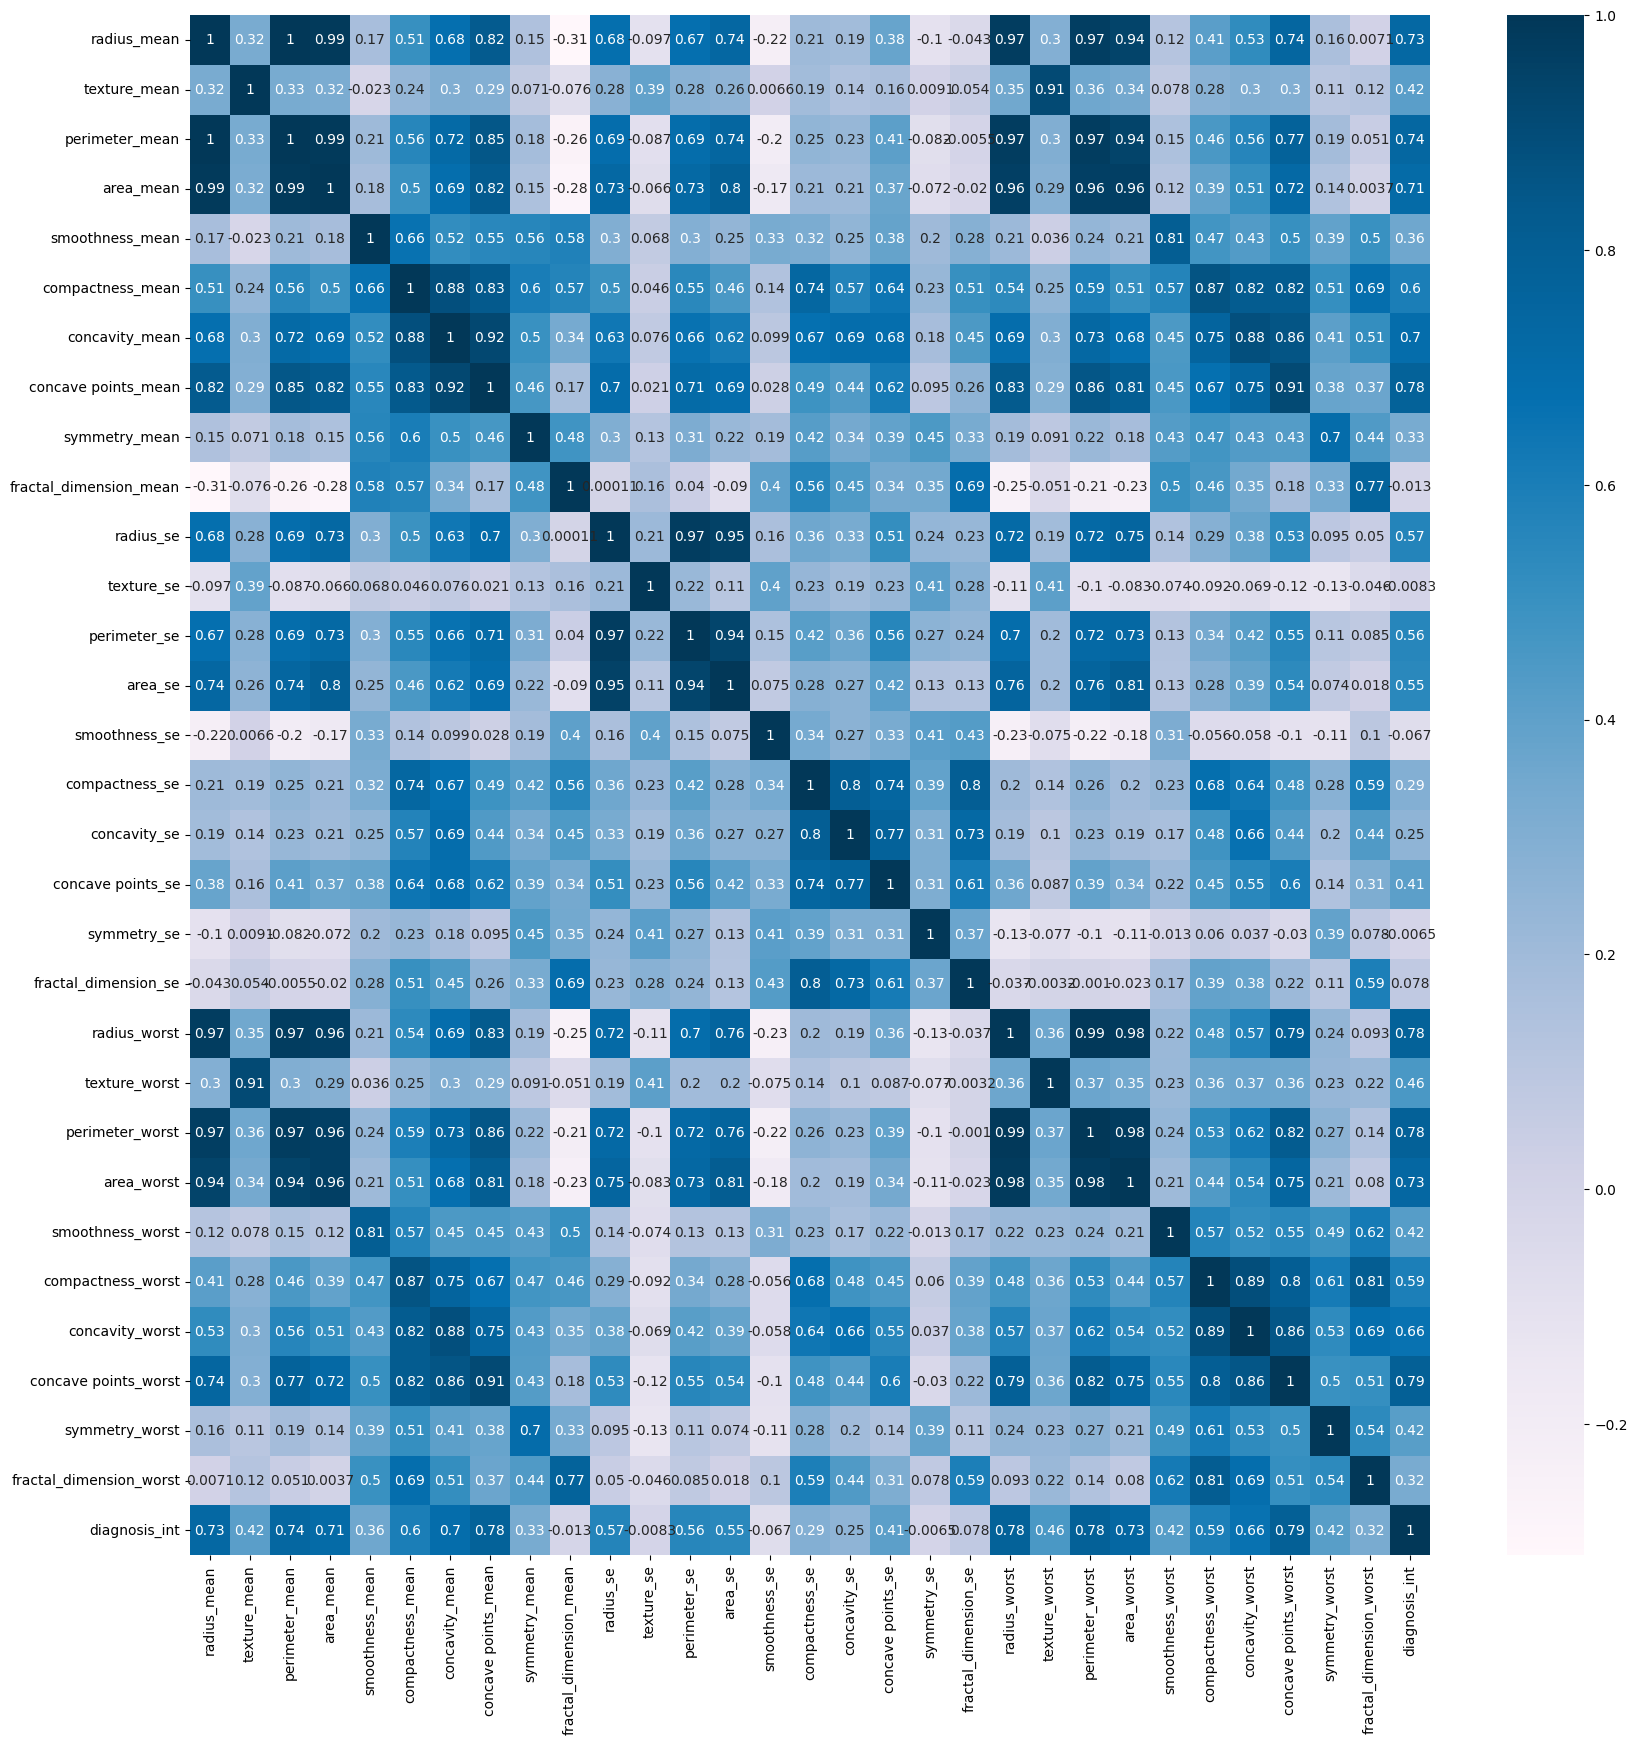

In [28]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate correlation matrix
cor = df.corr()

# Plot the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

## Filter Methods

Let's start feature selection with filter methods. This type of feature selection uses statistical methods to rank a given set of features. Moreover, it does this ranking regardless of the model you will be training on (i.e. you only need the feature values). When using these, it is important to note the types of features and target variable you have. Here are a few examples:

* Pearson Correlation (numeric features - numeric target, *exception: when target is 0/1 coded*)
* ANOVA f-test (numeric features - categorical target)
* Chi-squared (categorical features - categorical target)

Let's use some of these in the next cells.

### Correlation with the target variable

Let's start by determining which features are strongly correlated with the diagnosis (i.e. the target variable). Since we have numeric features and our target, although categorical, is 0/1 coded, we can use Pearson correlation to compute the scores for each feature. This is also categorized as *supervised* feature selection because we're taking into account the relationship of each feature with the target variable. Moreover, since only one variable's relationship to the target is taken at a time, this falls under *univariate feature selection*.

In [29]:
# Get the absolute value of the correlation
cor_target = abs(cor["diagnosis_int"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in relevant_features.iteritems()]

# Drop the target variable from the results
names.remove('diagnosis_int')

# Display the results
print(names)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


<ipython-input-29-c86cefea8dee>:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  names = [index for index, value in relevant_features.iteritems()]


Now try training the model again but only with the features in the columns you just gathered. You can observe that there is an improvement in the metrics compared to the model you trained earlier.

In [30]:
# Evaluate the model with new features
strong_features_eval_df = evaluate_model_on_features(df[names], Y)
strong_features_eval_df.index = ['Strong features']

# Append to results and display
results = results.append(strong_features_eval_df)
results.head()

<ipython-input-30-4512a738f2bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(strong_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.97619,0.964706,25


### Correlation with other features

You will now eliminate features which are highly correlated with each other. This helps remove redundant features thus resulting in a simpler model. Since the scores are calculated regardless of the target variable, this can be categorized under *unsupervised* feature selection.

For this, you will plot the correlation matrix of the features selected previously. Let's first visualize the correlation matrix again.

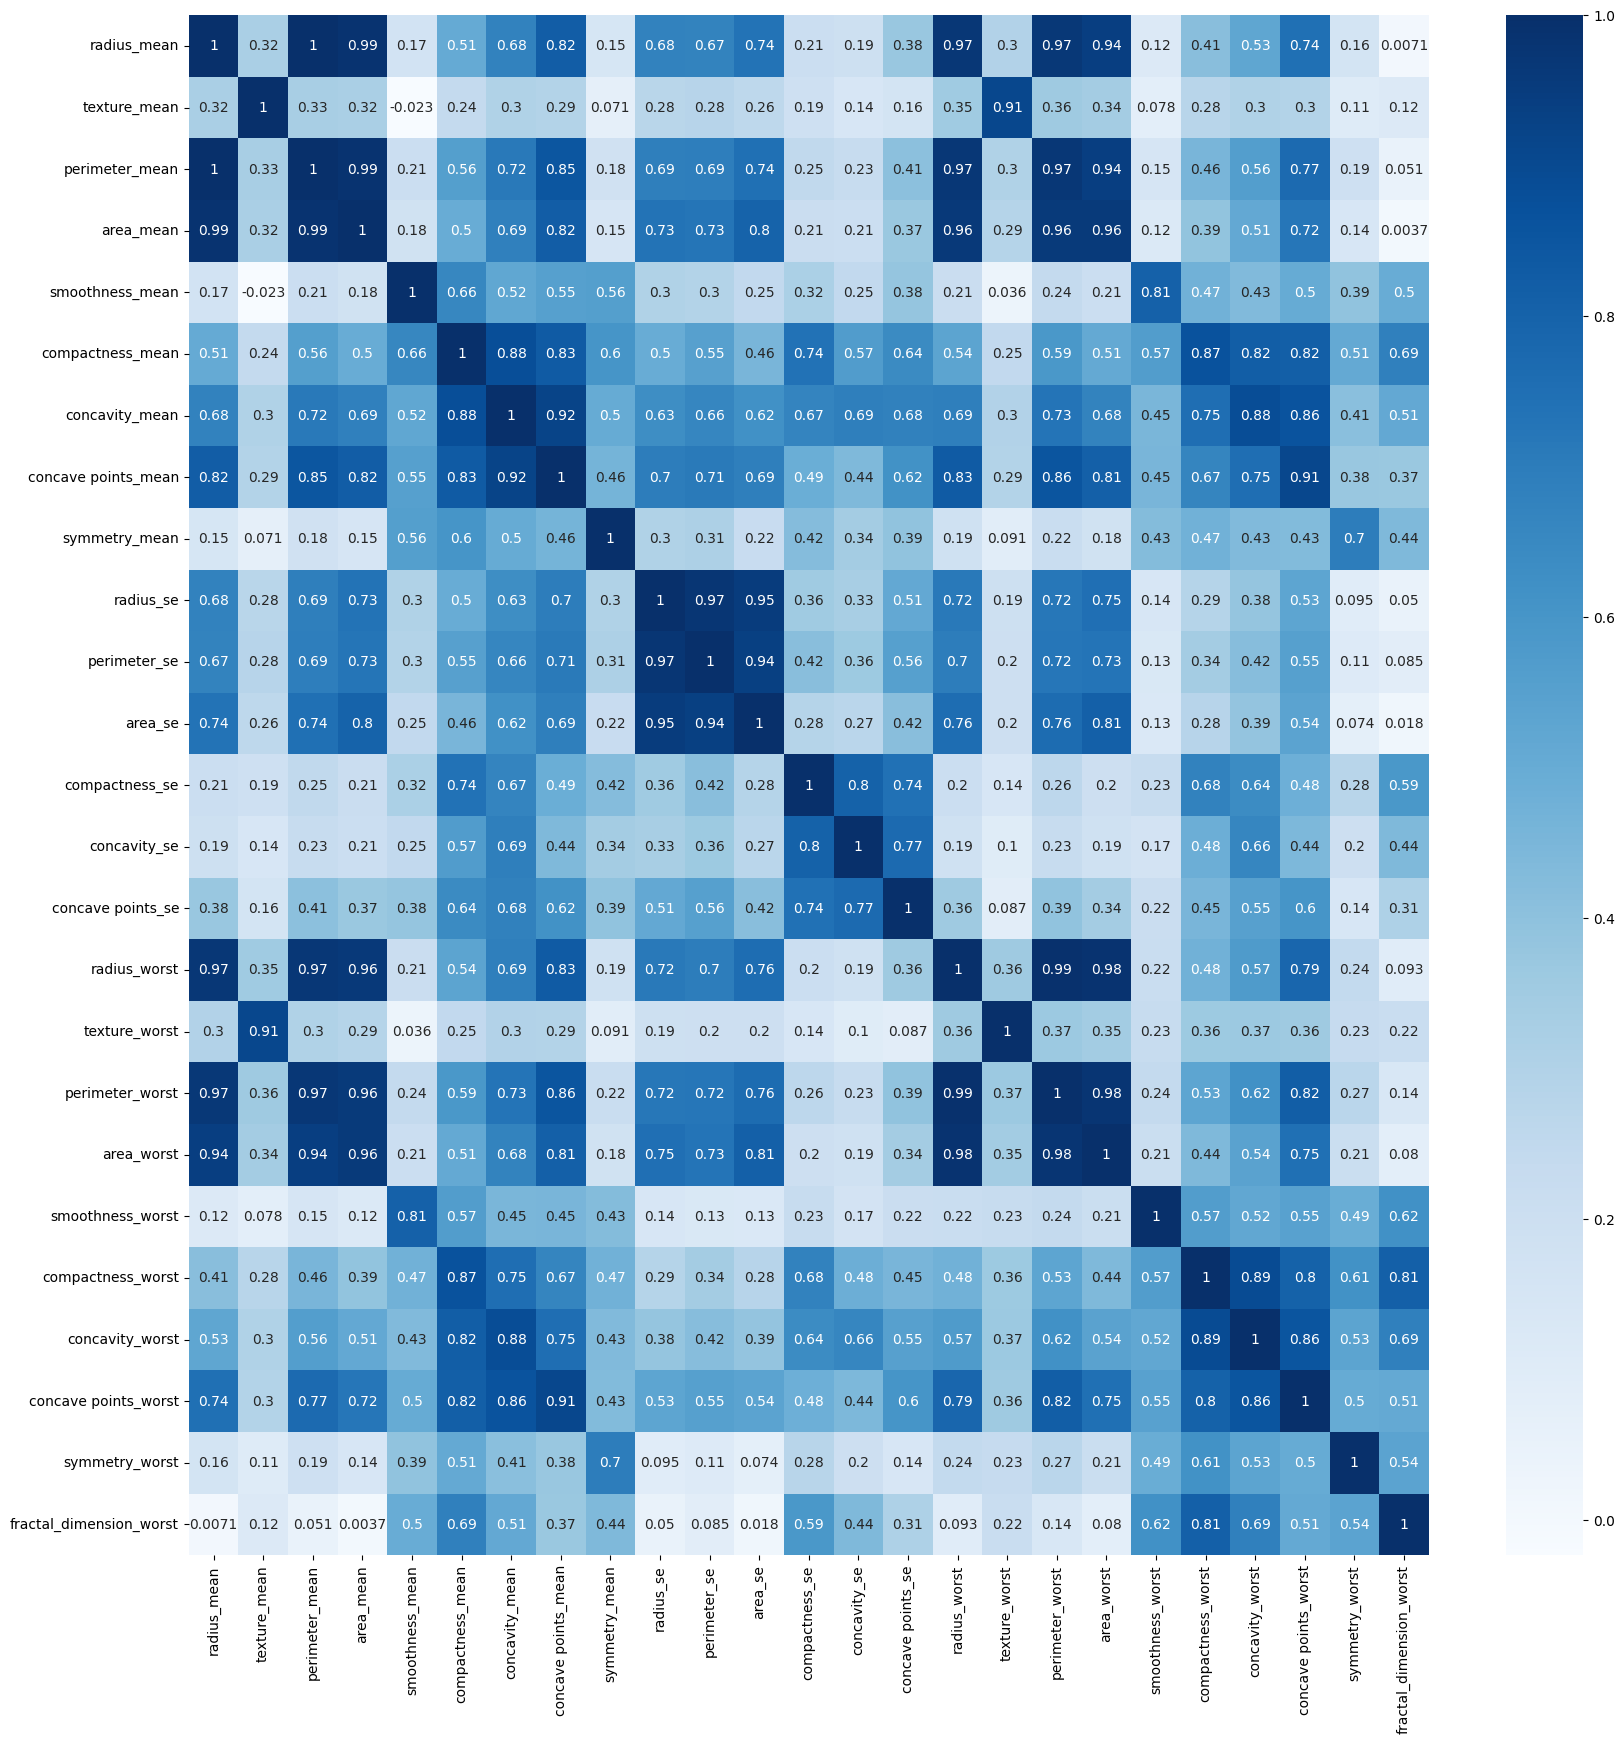

In [31]:
# Set figure size
plt.figure(figsize=(20,20))

# Calculate the correlation matrix for target relevant features that you previously determined
new_corr = df[names].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will see that `radius_mean` is highly correlated to `radius worst`, `perimeter_worst`, and `area_worst`. You can retain `radius_mean` and remove the rest of the features highly correlated to it.

Moreover, `concavity_mean` is highly correlated to `concave points_mean`. You will remove `concave points_mean` and retain `concavity_mean` from your set of features.

This is a more magnified view of the features that are highly correlated to each other.

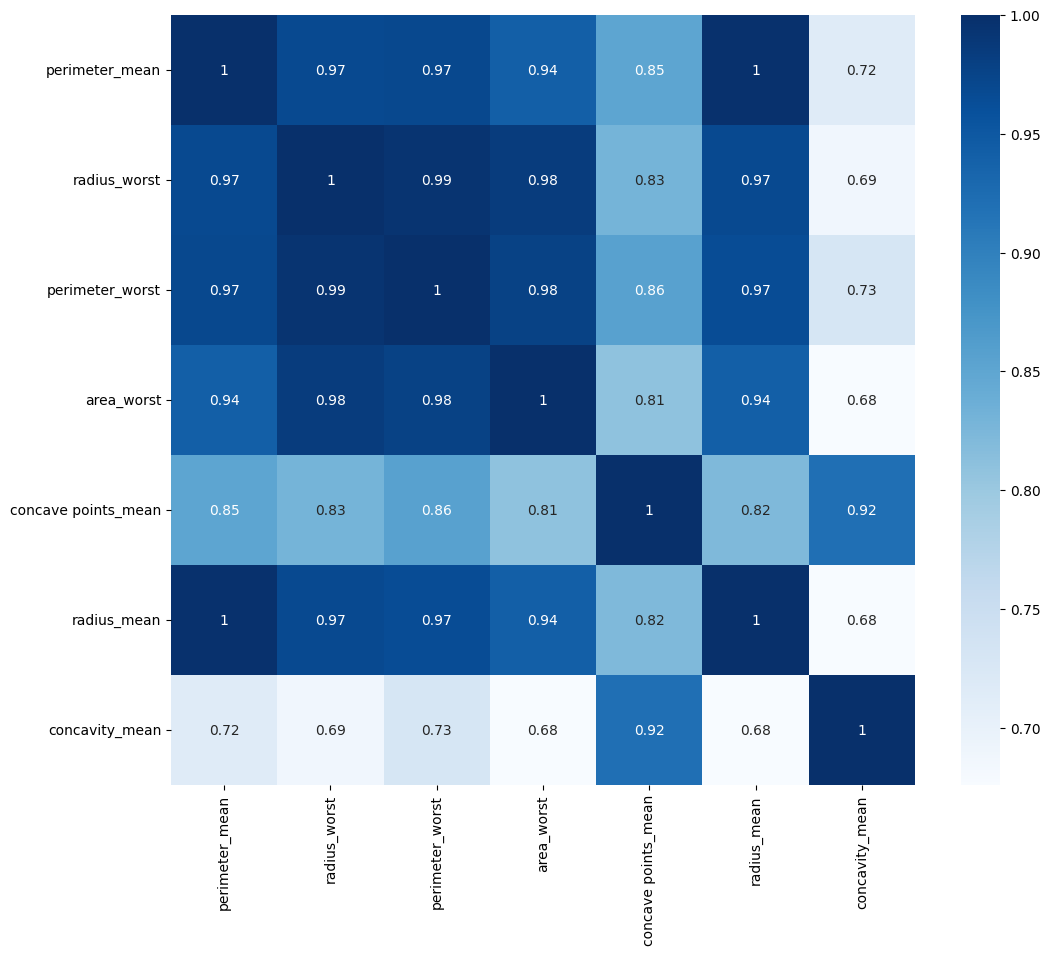

In [32]:
# Set figure size
plt.figure(figsize=(12,10))

# Select a subset of features
new_corr = df[['perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_mean', 'radius_mean', 'concavity_mean']].corr()

# Visualize the correlation matrix
sns.heatmap(new_corr, annot=True, cmap=plt.cm.Blues)
plt.show()

You will now evaluate the model on the features selected based on your observations. You can see that the metrics show the same values as when it was using 25 features. This indicates that you can get the same model performance even if you reduce the number of features. In other words, the 4 features you removed were indeed redundant and you only needed the ones you retained.

In [33]:
# Remove the features with high correlation to other features
subset_feature_corr_names = [x for x in names if x not in ['perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavepoints_mean']]

# Calculate and check evaluation metrics
subset_feature_eval_df = evaluate_model_on_features(df[subset_feature_corr_names], Y)
subset_feature_eval_df.index = ['Subset features']

# Append to results and display
results = results.append(subset_feature_eval_df)
results.head(n=10)

<ipython-input-33-2c99aab04f50>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(subset_feature_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.97619,0.964706,25
Subset features,0.974206,0.973684,0.953488,0.97619,0.964706,21


### Univariate Selection with Sci-Kit Learn

Sci-kit learn offers more filter methods in its feature selection module. Moreover, it also has convenience methods for how you would like to filter the features. You can see the available options here in the [official docs](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

For this exercise, you will compute the ANOVA F-values to select the top 20 features using `SelectKBest()`.

In [34]:
def univariate_selection():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # User SelectKBest to select top 20 features based on f-test
    selector = SelectKBest(f_classif, k=20)

    # Fit to scaled data, then transform it
    X_new = selector.fit_transform(X_train_scaled, Y_train)

    # Print the results
    feature_idx = selector.get_support()
    for name, included in zip(df.drop("diagnosis_int",1 ).columns, feature_idx):
        print("%s: %s" % (name, included))

    # Drop the target variable
    feature_names = df.drop("diagnosis_int",1 ).columns[feature_idx]

    return feature_names

You will now evaluate the model on the features selected by univariate selection.

In [35]:
univariate_feature_names = univariate_selection()

radius_mean: True
texture_mean: True
perimeter_mean: True
area_mean: True
smoothness_mean: False
compactness_mean: True
concavity_mean: True
concave points_mean: True
symmetry_mean: False
fractal_dimension_mean: False
radius_se: True
texture_se: False
perimeter_se: True
area_se: True
smoothness_se: False
compactness_se: False
concavity_se: False
concave points_se: True
symmetry_se: False
fractal_dimension_se: False
radius_worst: True
texture_worst: True
perimeter_worst: True
area_worst: True
smoothness_worst: True
compactness_worst: True
concavity_worst: True
concave points_worst: True
symmetry_worst: True
fractal_dimension_worst: False


<ipython-input-34-48ee13d7bde9>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  for name, included in zip(df.drop("diagnosis_int",1 ).columns, feature_idx):
<ipython-input-34-48ee13d7bde9>:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis_int",1 ).columns[feature_idx]


In [36]:
# Calculate and check model metrics
univariate_eval_df = evaluate_model_on_features(df[univariate_feature_names], Y)
univariate_eval_df.index = ['F-test']

# Append to results and display
results = results.append(univariate_eval_df)
results.head(n=10)

<ipython-input-36-50b875575d3b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(univariate_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.97619,0.964706,25
Subset features,0.974206,0.973684,0.953488,0.97619,0.964706,21
F-test,0.974206,0.973684,0.953488,0.97619,0.964706,20


You can see that the performance metrics are the same as in the previous section but it uses only 20 features.

## Wrapper Methods

Wrapper methods use a model to measure the effectiveness of a particular subset of features. As mentioned in class, one approach is to remove or add features sequentially. You can either start with 1 feature and gradually add until no improvement is made (forward selection), or do the reverse (backward selection). That can be done with the [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) class which uses k-fold cross validation scores to decide which features to add or remove. [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is similar to backwards elimination but uses feature importance scores to prune the number of features. You can also specify how many features to remove at each iteration of the recursion. Let's use this as the wrapper for our model below.

### Recursive Feature Elimination

You used the **RandomForestClassifier** as the model algorithm for which features should be selected. Now, you will use **Recursive Feature Elimination**, which wraps around the selected model to perform feature selection. This time, you can repeat the same task of selecting the top 20 features using RFE instead of SelectKBest.

In [39]:
def run_rfe():

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the model
    model = RandomForestClassifier(criterion='entropy', random_state=47)

    # Wrap RFE around the model
    rfe = RFE(estimator=model, n_features_to_select=20)

    # Fit RFE
    rfe = rfe.fit(X_train_scaled, Y_train)
    feature_names = df.drop("diagnosis_int",1 ).columns[rfe.get_support()]

    return feature_names

rfe_feature_names = run_rfe()

<ipython-input-39-7b24a53f5627>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis_int",1 ).columns[rfe.get_support()]


You will now evaluate the **RandomForestClassifier** on the features selected by RFE. You will see that there is a slight performance drop compared to the previous approaches.

In [40]:
# Calculate and check model metrics
rfe_eval_df = evaluate_model_on_features(df[rfe_feature_names], Y)
rfe_eval_df.index = ['RFE']

# Append to results and display
results = results.append(rfe_eval_df)
results.head(n=10)

<ipython-input-40-610d3cebc3c6>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(rfe_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.97619,0.964706,25
Subset features,0.974206,0.973684,0.953488,0.97619,0.964706,21
F-test,0.974206,0.973684,0.953488,0.97619,0.964706,20
RFE,0.967262,0.964912,0.931818,0.97619,0.953488,20


## Embedded Methods

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

### Feature Importances

**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

You can use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold.

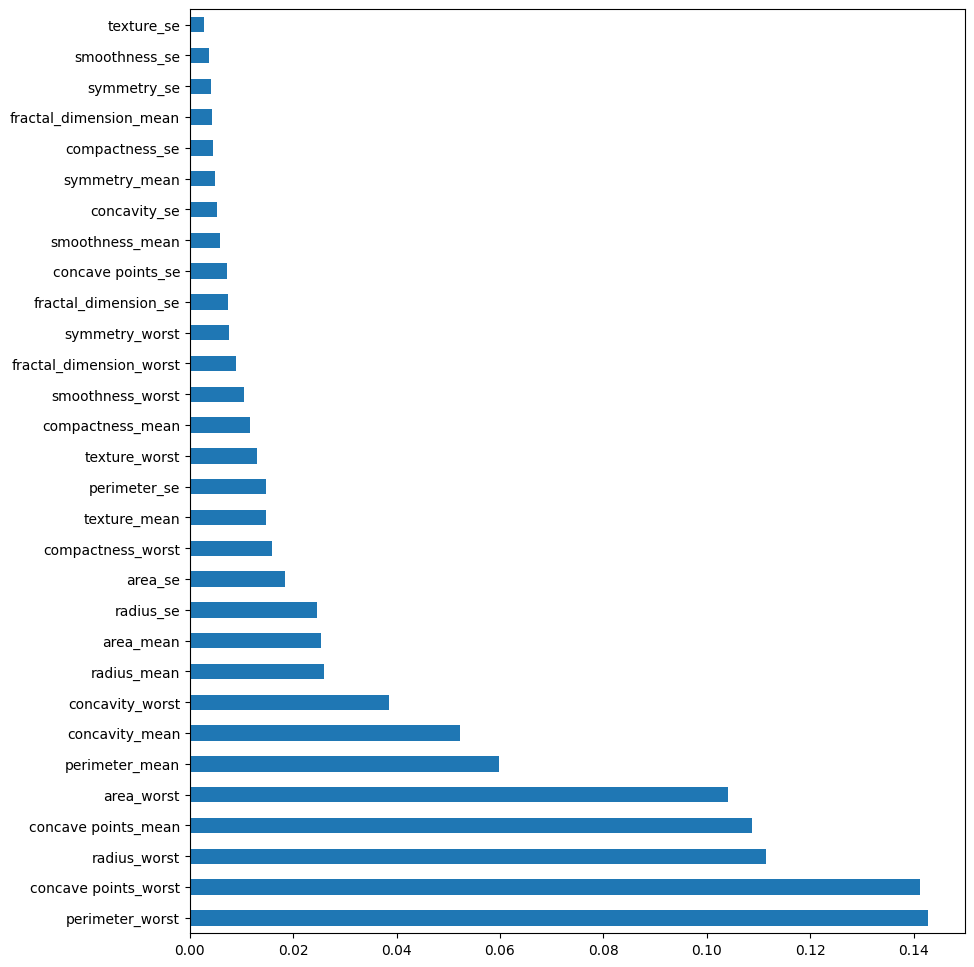

<ipython-input-41-d0fc62380388>:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis_int",1 ).columns[feature_idx]


In [41]:
def feature_importances_from_tree_based_model_():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # Define the model to use
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,Y_train)

    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()

    return model


def select_features_from_model(model):

    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = df.drop("diagnosis_int",1 ).columns[feature_idx]

    return feature_names

model = feature_importances_from_tree_based_model_()
feature_imp_feature_names = select_features_from_model(model)

In [42]:
# Calculate and check model metrics
feat_imp_eval_df = evaluate_model_on_features(df[feature_imp_feature_names], Y)
feat_imp_eval_df.index = ['Feature Importance']

# Append to results and display
results = results.append(feat_imp_eval_df)
results.head(n=10)

<ipython-input-42-a2a181e95454>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(feat_imp_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.97619,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.97619,0.964706,25
Subset features,0.974206,0.973684,0.953488,0.97619,0.964706,21
F-test,0.974206,0.973684,0.953488,0.97619,0.964706,20
RFE,0.967262,0.964912,0.931818,0.97619,0.953488,20
Feature Importance,0.967262,0.964912,0.931818,0.97619,0.953488,16


### L1 Regularization

L1 or Lasso Regulartization introduces a penalty term to the loss function which leads to the least important features being eliminated. Implementation in scikit-learn can be done with a [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) model as the learning algorithm. You can then use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features based on the LinearSVC model’s output of L1 regularization.

In [43]:
def run_l1_regularization():

    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select L1 regulated features from LinearSVC output
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = df.drop("diagnosis_int",1 ).columns[(selection.get_support())]

    return feature_names

l1reg_feature_names = run_l1_regularization()

<ipython-input-43-be3aef9164d9>:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feature_names = df.drop("diagnosis_int",1 ).columns[(selection.get_support())]


In [44]:
# Calculate and check model metrics
l1reg_eval_df = evaluate_model_on_features(df[l1reg_feature_names], Y)
l1reg_eval_df.index = ['L1 Reg']

# Append to results and display
results = results.append(l1reg_eval_df)
results.head(n=10)

<ipython-input-44-9df69d5f9fa2>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(l1reg_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count
All features,0.967262,0.964912,0.931818,0.976190,0.953488,30
Strong features,0.974206,0.973684,0.953488,0.976190,0.964706,25
Subset features,0.974206,0.973684,0.953488,0.976190,0.964706,21
F-test,0.974206,0.973684,0.953488,0.976190,0.964706,20
RFE,0.967262,0.964912,0.931818,0.976190,0.953488,20
Feature Importance,0.967262,0.964912,0.931818,0.976190,0.953488,16
L1 Reg,0.929563,0.929825,0.886364,0.928571,0.906977,18


With these results and also your domain knowledge, you can decide which set of features to use to train on the entire dataset. If you will be basing it on the f1 score, you may narrow it down to the `Strong features`, `Subset features` and `F-test` rows because they have the highest scores. If you want to save resources, the `F-test` will be the most optimal of these 3 because it uses the least number of features. On the other hand, if you find that all the resulting scores for all approaches are acceptable, then you may just go for the method with the smallest set of features.

## Wrap Up

That's it for this quick rundown of the different feature selection methods. As shown, you can do quick experiments with these because convenience modules are already available in libraries like sci-kit learn. It is a good idea to do this preprocessing step because not only will you save resources, you may even get better results than when you use all features. Try it out on your previous/upcoming projects and see what results you get!